In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'D://Work/dogs-vs-cats_small/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 357us/step - loss: 0.6145 - acc: 0.6665 - val_loss: 0.4352 - val_acc: 0.8480
Epoch 2/30
2000/2000 [==============================] - 1s 304us/step - loss: 0.4265 - acc: 0.7980 - val_loss: 0.3522 - val_acc: 0.8800
Epoch 3/30
2000/2000 [==============================] - 1s 300us/step - loss: 0.3601 - acc: 0.8420 - val_loss: 0.3135 - val_acc: 0.8820
Epoch 4/30
2000/2000 [==============================] - 1s 304us/step - loss: 0.3199 - acc: 0.8560 - val_loss: 0.2924 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 300us/step - loss: 0.2834 - acc: 0.8840 - val_loss: 0.2832 - val_acc: 0.8970
Epoch 6/30
2000/2000 [==============================] - 1s 302us/step - loss: 0.2609 - acc: 0.8980 - val_loss: 0.2761 - val_acc: 0.8770
Epoch 7/30
2000/2000 [==============================] - 1s 285us/step - loss: 0.2457 - acc: 0.9020 - val_loss: 0.2604 - val_acc: 0.8940


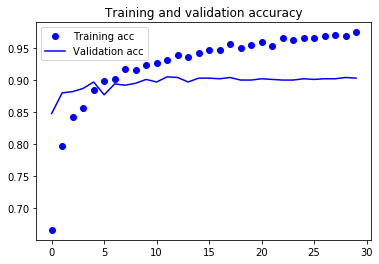

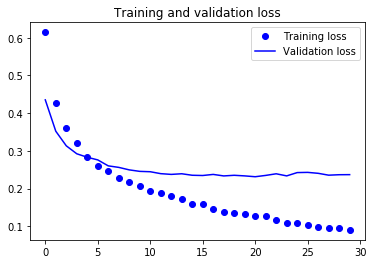

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [11]:
conv_base.trainable = False

In [12]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 13s - loss: 0.5974 - acc: 0.6905 - val_loss: 0.4196 - val_acc: 0.8190
Epoch 2/30
 - 13s - loss: 0.4932 - acc: 0.7730 - val_loss: 0.2844 - val_acc: 0.8580
Epoch 3/30
 - 13s - loss: 0.4418 - acc: 0.8015 - val_loss: 0.2080 - val_acc: 0.8680
Epoch 4/30
 - 13s - loss: 0.4082 - acc: 0.8185 - val_loss: 0.3825 - val_acc: 0.8800
Epoch 5/30
 - 12s - loss: 0.3897 - acc: 0.8185 - val_loss: 0.2939 - val_acc: 0.8880
Epoch 6/30
 - 12s - loss: 0.3802 - acc: 0.8395 - val_loss: 0.1755 - val_acc: 0.8860
Epoch 7/30
 - 12s - loss: 0.3670 - acc: 0.8340 - val_loss: 0.2422 - val_acc: 0.8930
Epoch 8/30
 - 12s - loss: 0.3612 - acc: 0.8440 - val_loss: 0.1229 - val_acc: 0.8930
Epoch 9/30
 - 12s - loss: 0.3496 - acc: 0.8520 - val_loss: 0.3502 - val_acc: 0.8960
Epoch 10/30
 - 12s - loss: 0.3346 - acc: 0.8555 - val_loss: 0.1924 - val_acc: 0.8830
Epoch 11/30
 - 12s - loss: 0.3476 - acc: 0.8470 - val_loss: 0.2686 - val_ac

In [14]:
model.save('D://Work/cats_and_dogs_small_3.h5')

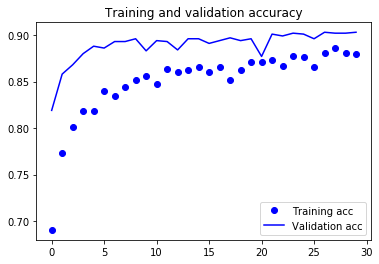

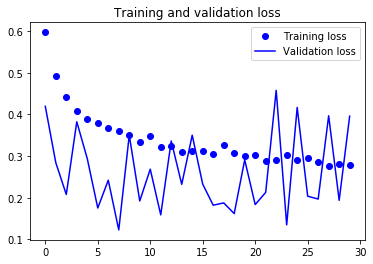

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 14s 142ms/step - loss: 0.2813 - acc: 0.8765 - val_loss: 0.3164 - val_acc: 0.9030
Epoch 2/100
100/100 [==============================] - 14s 140ms/step - loss: 0.2493 - acc: 0.9020 - val_loss: 0.3796 - val_acc: 0.9100
Epoch 3/100
100/100 [==============================] - 14s 141ms/step - loss: 0.2473 - acc: 0.8920 - val_loss: 0.1054 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 14s 141ms/step - loss: 0.2236 - acc: 0.9055 - val_loss: 0.1056 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 14s 139ms/step - loss: 0.2001 - acc: 0.9165 - val_loss: 0.0912 - val_acc: 0.9260
Epoch 6/100
100/100 [==============================] - 14s 144ms/step - loss: 0.2121 - acc: 0.9120 - val_loss: 0.0203 - val_acc: 0.9190
Epoch 7/100
100/100 [==============================] - 14s 143ms/step - loss: 0.1897 - acc: 0.9300 - val_loss: 0.1460 - val_acc: 0.9020
Epoch 8/100
100/100 [===========================

In [19]:
model.save('D://Work/cats_and_dogs_small_4.h5')

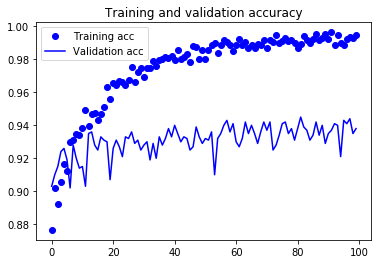

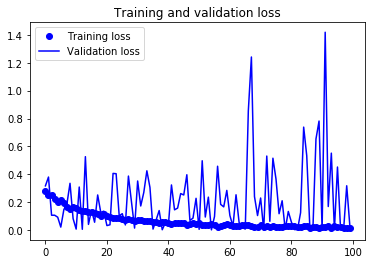

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

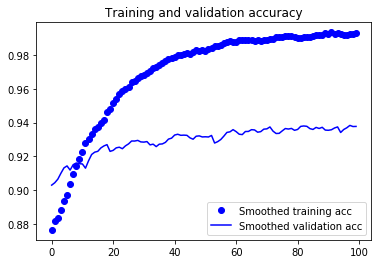

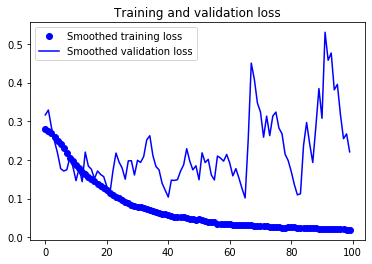

In [21]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9399999976158142
